In [6]:
import os
import numpy as np
import pandas as pd
import random
from scipy.optimize import nnls
import os, glob, re, csv
import glob
import nibabel as nib
import statsmodels.api as sm
from nilearn import datasets
from nilearn.image import resample_to_img
import pandas as pd
from scipy.stats import ttest_1samp
from nilearn import plotting, datasets
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
import json

In [7]:
# Set random seeds for reproducibility
np.random.seed(42)

In [60]:
# SET MAIN HYPERPARAMETERS
# TRAIT_LABEL = "Contemplating"  

TRAIT_SETS = {
    "all_13": [
        "Open-minded","feeling Affectionate","Attentive","Assertive",
        "feeling Gloomy","feeling Peaceful","Agreeable","Judging",
        "feeling Angry","feeling Bewildered","Impulsive",
        "Self-disciplined","Contemplating"
    ],
    "mental_8": [
        "feeling Affectionate","feeling Gloomy","feeling Peaceful",
        "feeling Angry","feeling Bewildered","Judging",
        "Contemplating","Attentive"
    ],
    "personality_5": [
        "Open-minded","Agreeable","Assertive",
        "Self-disciplined","Impulsive"
    ],
    "trait_9": [
        "Open-minded","feeling Affectionate","Attentive","Assertive",
        "Agreeable","Judging","feeling Angry","Self-disciplined","Contemplating"
    ]
}

# Select model here: choose one key from TRAIT_SETS
model_key = "all_13"   # options: all_13, mental_8, personality_5, trait_9
traits    = TRAIT_SETS[model_key]

# ALL_TRAIT_LABELS = [
    #"Open-minded","feeling Affectionate","Attentive","Assertive",
    #"feeling Gloomy","feeling Peaceful","Agreeable","Judging",
    #"feeling Angry","feeling Bewildered","Impulsive",
    #"Self-disciplined","Contemplating"
#]
ALL_TRAIT_SAVE_STRS = [t.replace(" ","_").replace("-","_")
                       for t in traits]
# Our 13 trait labels 
# ["Open-minded", "feeling Affectionate", "Attentive", "Assertive", "feeling Gloomy", "feeling Peaceful", "Agreeable", "Judging", "feeling Angry", "feeling Bewildered", "Impulsive", "Self-disciplined", "Contemplating"]

#TRAIT_LABEL_SAVE_STRING = TRAIT_LABEL.replace(" ", "_").replace("-", "_")
STIMULUS_LABEL_SAVE_STRING = "slumlordreach"

# Set window shift amount
shift_window = 20  #shifts the window by x TRs 

# Set smoothing setting to either use smoothed trait RDMs or the un-smoothed RDMs
smoothing_setting = "_no_smoothing"    # set to _no_smoothing or set to "" for smoothed RDMs

# Parcel of interest for power analysis
PARCEL_OF_INTEREST = 68          # LH_TempPar_1


In [13]:
# Load the BOLD cleaned image
bold_sub = "sub-034"
bold_img = nib.load(f'/Volumes/Passport/fmriprep/derivatives/{STIMULUS_LABEL_SAVE_STRING}_cleaned/{bold_sub}/func/{bold_sub}_task-{STIMULUS_LABEL_SAVE_STRING}_cleaned_desc-masked_bold.nii.gz')

# Print voxel size (spatial resolution) and TR (temporal resolution)
zooms = bold_img.header.get_zooms()
print(f"Voxel size (mm): {zooms[:3]}")
print(f"TR (s): {zooms[3]}")
print(f"Shape {bold_img.shape}")

Voxel size (mm): (3.0, 3.0, 4.0)
TR (s): 1.5
Shape (65, 77, 49, 160)


In [16]:
# ──────────────────────────────────────────────────────────────
# 0) PATHS & I/O
# ──────────────────────────────────────────────────────────────
root_dir  = "/Volumes/Passport/fmriprep"          # ←  same as in cleaning script
deriv_dir = os.path.join(root_dir, "derivatives") #   (don’t hard-code “subjects” yet)



# output from your behaviour-model RSA
for trait_long, trait_save in zip(traits, ALL_TRAIT_SAVE_STRS):
    rdm_path = os.path.join(
        deriv_dir, "RDMs_behavior",
        f"{STIMULUS_LABEL_SAVE_STRING}_{trait_save}_RDM{smoothing_setting}.npy"     
    )
    model_rdm = np.load(rdm_path)


perm_dir = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING, "perm_test_neural_shift"
)


#Output path for parcel results for later power analysis
SAVE_PATH = os.path.join(
    perm_dir,
    f"{STIMULUS_LABEL_SAVE_STRING}_parcel{PARCEL_OF_INTEREST}_{model_key}_subject_s1_perms.npy"
)

In [45]:
# ──────────────────────────────────────────────────────────────
# 1) SUBJECT / RUN FILTERS  (copy-paste verbatim)  ─────────────
# ──────────────────────────────────────────────────────────────
exclude_subs = {
    "sub-317","sub-335"
}
exclude_sub_runs = []
target_subject = None     # e.g. "sub-002" to run a single person


In [46]:
# ----------------------------------------------------------------
# 2)  BUILD SUBJECT LIST  (from cleaned derivatives)  ------------
# ----------------------------------------------------------------
cleaned_root = os.path.join(deriv_dir, f"{STIMULUS_LABEL_SAVE_STRING}_cleaned")
all_subs     = sorted(
    d for d in os.listdir(cleaned_root) if d.startswith("sub-")
)
if target_subject:
    if target_subject not in all_subs:
        raise ValueError(f"{target_subject} not found in {cleaned_root}")
    subjects = [target_subject]
else:
    subjects = [s for s in all_subs if s not in exclude_subs]

print("Subjects to process →", ", ".join(subjects))

Subjects to process → sub-016, sub-034, sub-065, sub-066, sub-084, sub-089, sub-095, sub-096, sub-106, sub-111, sub-132, sub-133, sub-134, sub-135, sub-136, sub-137, sub-139, sub-140, sub-141, sub-142, sub-143, sub-144, sub-145, sub-195, sub-199, sub-268, sub-316, sub-318, sub-319, sub-320, sub-321, sub-322, sub-323, sub-324, sub-325, sub-326, sub-327, sub-328, sub-329, sub-330, sub-331, sub-332, sub-333, sub-334, sub-336, sub-337, sub-338, sub-339, sub-340, sub-341, sub-342, sub-343, sub-344, sub-345


In [14]:
# ──────────────────────────────────────────────────────────────
# FETCH SCHAEFER ATLAS  ─────────────────────────────────────
# ──────────────────────────────────────────────────────────────

# Schaefer parcel/atlas parameters
n_rois = 200
yeo_networks = 17
resolution_mm = 2                   # resolution of your Schaefer atlas (double check!)

schaefer    = datasets.fetch_atlas_schaefer_2018(
                 n_rois=n_rois,
                 yeo_networks=yeo_networks,
                 resolution_mm=resolution_mm
             )
atlas_img   = nib.load(schaefer['maps'])  # default 2mm MNI - but our images 3x3x4 (Pieman and others) OR 2.5^3 (ie., Black and Forgot)

atlas_resampled = resample_to_img(atlas_img, bold_img, interpolation='nearest')
atlas_data     = atlas_resampled.get_fdata()



# Change Schaeffer Labels so 0 is whole brain and 1 corresponds to 1st ROI
labels = schaefer['labels']
# change to string and remove excess
labels = [l.replace(b'17Networks_', b'').decode('utf-8') for l in labels]
# Prepend background label
labels = np.insert(labels, 0, "Background")

In [48]:
# ─── PERMUTATION TESTING Pipeline (s₁…sₙ) ────────────────────────────────
from scipy.optimize import nnls
from tqdm import tqdm

def vectorize_rdm(rdm):
    idx = np.tril_indices(rdm.shape[0], k=-1)
    return rdm[idx]

# 9.1) load all subject‐run CSVs with betas 
multi_csvs = glob.glob(os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING,
    "multi_regression","subject_results",
    f"*_{STIMULUS_LABEL_SAVE_STRING}_multi_parcel_RSA_NNLS_{model_key}{smoothing_setting}.csv"
))

# assert we have one file per subject (add dictionary for different stimuli later)
assert len(multi_csvs) == 54, (                     
    f"Expected 75 files, but found {len(multi_csvs)}"
)

df_list = []
for fn in multi_csvs:
    df = pd.read_csv(fn)
    df['unit'] = df['subject'] + "_" + df['run'].astype(str)
    df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

trait_cols = ALL_TRAIT_SAVE_STRS
n_traits  = len(trait_cols)

# 9.2) compute observed s_k per parcel for k=1…n_traits
observed = {}
# sort-and-sum top-k per row, then average by parcel
for k in range(1, n_traits+1):
    # descending sort, sum top k
    all_df[f's{k}'] = (
        np.sort(all_df[trait_cols].values, axis=1) # 1) sort each row ascending
        [:, ::-1]   # 2) reverse to descending 
        [:, :k]      # 3) take top-k
        .sum(axis=1)  # 4) sum across rows
    )
    observed[k] = all_df.groupby('parcel_num')[f's{k}'].mean()

# 9.3) precompute & cache every neural RDM (unchanged)
neural_rdm_cache = {}
for sub in subjects:
    func_dir = os.path.join(cleaned_root, sub, "func")
    run_pat  = os.path.join(func_dir,
        f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_run-*_*cleaned_desc-masked_bold.nii.gz"
    )
    single_pat = os.path.join(func_dir,
        f"{sub}_task-{STIMULUS_LABEL_SAVE_STRING}_cleaned_desc-masked_bold.nii.gz"
    )
    bold_files = sorted(glob.glob(run_pat)) + sorted(glob.glob(single_pat))
    for bf in bold_files:
        m = re.search(r"_run-(\d+)_", os.path.basename(bf))
        run = m.group(1) if m else "NA"
        if (sub, run) in exclude_sub_runs: 
            continue
        print("Attempting to load:", bf)  # debug line for when files get corrupted
        img = nib.load(bf)
        atlas_res = resample_to_img(atlas_img, img, interpolation='nearest')
        atlas_dat = atlas_res.get_fdata().astype(int)
        bold_dat  = img.get_fdata()
        for pid in range(1, n_rois+1):
            mask = atlas_dat == pid
            if not mask.any(): 
                continue
            # 1 - corr → RDM
            corr = np.corrcoef(bold_dat[mask,:].T)
            neural_rdm_cache[(sub, run, pid)] = (1 - corr).astype(np.float32)

    

# 9.4) load behavior RDMs (unchanged)
behavior_rdms = {
    trait: np.load(os.path.join(
        deriv_dir, "RDMs_behavior",
        f"{STIMULUS_LABEL_SAVE_STRING}_{sstr}_RDM{smoothing_setting}.npy"
    ))
    for trait, sstr in zip(traits, ALL_TRAIT_SAVE_STRS)
}

# 9.5) build null distributions for sₖ
n_perm = 100
parcel_ids = list(observed[1].index)
nulls = {k: {pid: [] for pid in parcel_ids} for k in range(1, n_traits+1)}

# 
from collections import defaultdict
subj_perm_vals = defaultdict(list)   # {(sub, run): [s1_perm0, s1_perm1, ...]}

n_tr   = next(iter(behavior_rdms.values())).shape[0]

assert n_tr == 160, f"Expected 160 timepoints, got {n_tr}"

for i in tqdm(range(n_perm), desc="Permutations"):
    
    
    # accumulate sums & counts for each k & parcel
    sums   = {k: {pid: 0.0 for pid in parcel_ids} for k in range(1, n_traits+1)}
    counts = {k: {pid: 0   for pid in parcel_ids} for k in range(1, n_traits+1)}

    for (sub, run, pid), rdm in neural_rdm_cache.items():
        # random circular TR shift ≥20
        shift = np.random.randint(shift_window, n_tr-shift_window)
        # apply circular shift to neural RDM
        rolled_rdm = np.roll(np.roll(rdm, shift, axis=0), shift, axis=1)
        y = vectorize_rdm(rolled_rdm)
        X = np.column_stack([np.ones_like(y)] +
                             [vectorize_rdm(behavior_rdms[t]) for t in traits])
        coef, _    = nnls(X, y)
        betas      = coef[1:]                     # drop intercept
        top_sorted = np.sort(betas)[::-1]         # descending

        # for each k, sum top-k betas
        for k in range(1, n_traits+1):
            s_k = top_sorted[:k].sum()
            sums[k][pid]   += s_k
            counts[k][pid] += 1

            if pid == PARCEL_OF_INTEREST and k == 1:
                # key = (subject, run). We'll pool across runs later → subject average
                subj_perm_vals[(sub, run)].append(s_k)

    # record mean null s_k for each parcel
    for k in range(1, n_traits+1):
        for pid in parcel_ids:
            nulls[k][pid].append(sums[k][pid] / counts[k][pid])


# ------------------------------------------------------------
# Build subject × permutation matrix for specific parcel   
# ------------------------------------------------------------
subjects_unique = sorted({sub for (sub, _run) in subj_perm_vals})
n_s   = len(subjects_unique)
n_p   = n_perm

perm_matrix = np.zeros((n_p, n_s), dtype=np.float32)

for s_idx, sub in enumerate(subjects_unique):

    # gather **all** run lists recorded for this subject
    run_arrays = [
        np.asarray(vals, dtype=np.float32)      # shape (n_perm,)
        for (s, r), vals in subj_perm_vals.items()
        if s == sub
    ]

    if not run_arrays:
        raise ValueError(f"No permutation s₁ values stored for subject {sub}")

    # stack → shape (n_runs_for_sub, n_perm)  then average over runs axis-0
    run_stack = np.vstack(run_arrays)
    perm_matrix[:, s_idx] = run_stack.mean(axis=0)

# ─── ensure the output directory exists ────────────────────────────
out_dir = os.path.dirname(SAVE_PATH)
os.makedirs(out_dir, exist_ok=True)

# save caches
np.save(SAVE_PATH, perm_matrix)
print(f"✅ Saved subject-level permutation s₁ values → {SAVE_PATH}")

# ------------------------------------------------------------
# Build OBSERVED s₁ vector (same parcel, averaged across available runs)
# ------------------------------------------------------------
obs_s1_by_subject = []

for sub in subjects_unique:
    rows = all_df[
        (all_df.subject == sub) &
        (all_df.parcel_num == PARCEL_OF_INTEREST)
    ]
    obs_s1_by_subject.append(rows['s1'].mean())

obs_s1 = np.asarray(obs_s1_by_subject, dtype=np.float32)
np.save(os.path.join(perm_dir,
        f"{STIMULUS_LABEL_SAVE_STRING}_parcel{PARCEL_OF_INTEREST}_{model_key}_observed_s1.npy"), obs_s1)
print(f"✅ Saved observed s₁ values for parcel {PARCEL_OF_INTEREST}")

# 9.6) compare observed vs null → p-values for every (k, parcel)
results = []
for k in range(1, n_traits+1):
    for pid, obs_val in observed[k].items():
        dist = np.array(nulls[k][pid])
        pval = (np.sum(dist >= obs_val) + 1) / (n_perm + 1)
        results.append((k, pid, obs_val, pval, pval < .05))

df_perm = pd.DataFrame(
    results,
    columns=['k', 'parcel_num', 'observed_s', 'p_value', 'significant_p05']
)

# 9.7) add parcel labels and save
parcel_labels = pd.DataFrame({
    'parcel_num': np.arange(1, len(labels)),
    'parcel_label': labels[1:]
})
# ─── define & create output folder ─────────────────────────────────────────
perm_dir = os.path.join(
    deriv_dir, "RSA_stats", STIMULUS_LABEL_SAVE_STRING, "perm_test_neural_shift"
)
os.makedirs(perm_dir, exist_ok=True)


df_perm = df_perm.merge(parcel_labels, on='parcel_num')
out_csv = os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_perm_test_{model_key}_allks{smoothing_setting}.csv")
df_perm.to_csv(out_csv, index=False)
print(f"✅ Permutation results for k=1…{n_traits} saved → {out_csv}")

Attempting to load: /Volumes/Passport/fmriprep/derivatives/notthefallintact_cleaned/sub-016/func/sub-016_task-notthefallintact_cleaned_desc-masked_bold.nii.gz
Attempting to load: /Volumes/Passport/fmriprep/derivatives/notthefallintact_cleaned/sub-034/func/sub-034_task-notthefallintact_cleaned_desc-masked_bold.nii.gz
Attempting to load: /Volumes/Passport/fmriprep/derivatives/notthefallintact_cleaned/sub-065/func/sub-065_task-notthefallintact_cleaned_desc-masked_bold.nii.gz
Attempting to load: /Volumes/Passport/fmriprep/derivatives/notthefallintact_cleaned/sub-066/func/sub-066_task-notthefallintact_cleaned_desc-masked_bold.nii.gz
Attempting to load: /Volumes/Passport/fmriprep/derivatives/notthefallintact_cleaned/sub-084/func/sub-084_task-notthefallintact_cleaned_desc-masked_bold.nii.gz
Attempting to load: /Volumes/Passport/fmriprep/derivatives/notthefallintact_cleaned/sub-089/func/sub-089_task-notthefallintact_cleaned_desc-masked_bold.nii.gz
Attempting to load: /Volumes/Passport/fmriprep

Permutations: 100%|██████████| 100/100 [34:19<00:00, 20.60s/it]

✅ Saved subject-level permutation s₁ values → /Volumes/Passport/fmriprep/derivatives/RSA_stats/notthefallintact/perm_test_neural_shift/notthefallintact_parcel68_trait_9_subject_s1_perms.npy
✅ Saved observed s₁ values for parcel 68
✅ Permutation results for k=1…9 saved → /Volumes/Passport/fmriprep/derivatives/RSA_stats/notthefallintact/perm_test_neural_shift/notthefallintact_perm_test_trait_9_allks_no_smoothing.csv


perm.shape = (100, 54)
obs.shape  = (54,)
Parcel-68, k=1, overall p-value (should be ~0.01): 0.7723


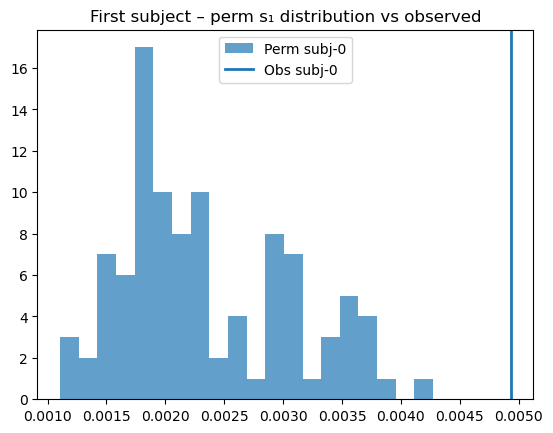

In [49]:
perm_path   = os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_parcel{PARCEL_OF_INTEREST}_{model_key}_subject_s1_perms.npy")
obs_path    = os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_parcel{PARCEL_OF_INTEREST}_{model_key}_observed_s1.npy")

# 1) Load arrays
perm = np.load(perm_path)         # shape (n_perm, n_subj)
obs  = np.load(obs_path)          # shape (n_subj,)

print(f"perm.shape = {perm.shape}")
print(f"obs.shape  = {obs.shape}")

# 2) Basic shape & dtype checks
n_perm, n_subj = perm.shape
assert obs.shape == (n_subj,),  "obs vector length must match #columns of perm"
assert perm.dtype == np.float32 and obs.dtype == np.float32, "dtype mismatch"
assert not np.isnan(perm).any(), "NaNs found in perm matrix"
assert not np.isnan(obs).any(),  "NaNs found in obs vector"

# 3) Quick “global” p-value check (mean-across-subjects)
perm_means = perm.mean(axis=1)        # shape (n_perm,)
obs_mean   = obs.mean()               # scalar
p_val = ((perm_means >= obs_mean).sum() + 1) / (n_perm + 1)
print(f"Parcel-{PARCEL_OF_INTEREST}, k=1, overall p-value (should be ~0.01): {p_val:.4f}")

# 5) Quick per-subject distribution sanity (optional)
import matplotlib.pyplot as plt
plt.hist(perm[:,0], bins=20, alpha=.7, label='Perm subj-0'); plt.axvline(obs[0], lw=2,label='Obs subj-0')
plt.title('First subject – perm s₁ distribution vs observed'); plt.legend(); plt.show()

In [50]:
observed_df = pd.DataFrame(observed)
print(observed_df)

                   1         2         3         4         5         6  \
parcel_num                                                               
1           0.002451  0.003905  0.004983  0.005684  0.006024  0.006144   
2           0.002535  0.003990  0.005046  0.005759  0.006176  0.006298   
3           0.002470  0.003879  0.004925  0.005650  0.005995  0.006095   
4           0.002433  0.003899  0.004963  0.005618  0.005940  0.006028   
5           0.002538  0.003884  0.004851  0.005524  0.005911  0.006028   
...              ...       ...       ...       ...       ...       ...   
196         0.002033  0.003249  0.004171  0.004787  0.005150  0.005258   
197         0.002133  0.003454  0.004420  0.005057  0.005351  0.005423   
198         0.002170  0.003502  0.004430  0.005044  0.005343  0.005436   
199         0.002394  0.003807  0.004816  0.005465  0.005788  0.005866   
200         0.002205  0.003538  0.004492  0.005116  0.005474  0.005566   

                   7         8       

In [51]:
df_perm = pd.read_csv(out_csv)
print(df_perm.info())
print(df_perm.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   k                1800 non-null   int64  
 1   parcel_num       1800 non-null   int64  
 2   observed_s       1800 non-null   float64
 3   p_value          1800 non-null   float64
 4   significant_p05  1800 non-null   bool   
 5   parcel_label     1800 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 72.2+ KB
None
   k  parcel_num  observed_s   p_value  significant_p05          parcel_label
0  1           1    0.002451  0.277228            False    LH_VisCent_ExStr_1
1  1           2    0.002535  0.306931            False    LH_VisCent_ExStr_2
2  1           3    0.002470  0.396040            False  LH_VisCent_Striate_1
3  1           4    0.002433  0.227723            False    LH_VisCent_ExStr_3
4  1           5    0.002538  0.138614            False    

In [61]:
# Load CSV file 
perm_csv_path = f"/Volumes/Passport/fmriprep/derivatives/RSA_stats/{STIMULUS_LABEL_SAVE_STRING}/perm_test_neural_shift/{STIMULUS_LABEL_SAVE_STRING}_perm_test_{model_key}_allks{smoothing_setting}.csv"
df_perm1 = pd.read_csv(perm_csv_path)

# Filter to only the k=1 results
df_perm1['k'] = df_perm1['k'].astype(int)
df_k1 = df_perm1[df_perm1['k'] == 1].copy()
df_k1['parcel_num'] = df_k1['parcel_num'].astype(int)


# 1) Extract the integer parcel map
atlas_data = atlas_resampled.get_fdata().astype(int)

# 2) Create maps
p_map               = np.zeros(atlas_data.shape, dtype=float)               # unthresholded
p_map_thresholded   = np.full(atlas_data.shape, np.nan, dtype=float)        # use NaN for masking
s_map               = np.zeros(atlas_data.shape, dtype=float)               # unthresholded
s_map_thresholded   = np.zeros(atlas_data.shape, dtype=float)               # 0 for non-sig

# 3) Fill in each parcel
for _, row in df_k1.iterrows():
    pid  = int(row['parcel_num'])
    pval = float(row['p_value'])
    sval = float(row['observed_s'])

    p_map[atlas_data == pid] = pval
    s_map[atlas_data == pid] = sval

    if pval < 0.05:
        p_map_thresholded[atlas_data == pid] = pval
        s_map_thresholded[atlas_data == pid] = sval

# 4) Wrap and save NIfTI images
p_img = nib.Nifti1Image(p_map, atlas_resampled.affine, atlas_resampled.header)
nib.save(p_img, os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_perm_pmap_{model_key}_k1{smoothing_setting}.nii.gz"))
print("✅ unthresholded k=1 p-value map saved")

p_img_thresh = nib.Nifti1Image(p_map_thresholded, atlas_resampled.affine, atlas_resampled.header)
nib.save(p_img_thresh, os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_perm_pmap_{model_key}_k1_thresh05{smoothing_setting}.nii.gz"))
print("✅ thresholded k=1 p-value map (NaN-masked) saved")

s_img = nib.Nifti1Image(s_map, atlas_resampled.affine, atlas_resampled.header)
nib.save(s_img, os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}perm_smap_{model_key}_k1{smoothing_setting}.nii.gz"))
print("✅ k=1 observed s-value map saved")

s_img_thresh = nib.Nifti1Image(s_map_thresholded, atlas_resampled.affine, atlas_resampled.header)
nib.save(s_img_thresh, os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_perm_smap_{model_key}_k1_thresh05{smoothing_setting}.nii.gz"))
print("✅ thresholded k=1 s-value map saved")

# 5) Save -p map for MRIcroGL visualization
neg_p_map = -1.0 * p_map

neg_p_img = nib.Nifti1Image(neg_p_map, atlas_resampled.affine, atlas_resampled.header)
nib.save(neg_p_img, os.path.join(perm_dir, f"{STIMULUS_LABEL_SAVE_STRING}_perm_neg_pmap_{model_key}_k1{smoothing_setting}.nii.gz"))
print("✅ negative p-value map (p * -1) saved for visualization")

# Optional: Summary for verification
n_sig_parcels = df_k1[df_k1['p_value'] < 0.05]['parcel_num'].nunique()
print(f"Significant parcels (p < 0.05): {n_sig_parcels}")
print("Nonzero thresholded voxels in s_map:", np.count_nonzero(s_map_thresholded))
print("Non-NaN voxels in thresholded p_map:", np.count_nonzero(~np.isnan(p_map_thresholded)))



✅ unthresholded k=1 p-value map saved
✅ thresholded k=1 p-value map (NaN-masked) saved
✅ k=1 observed s-value map saved
✅ thresholded k=1 s-value map saved
✅ negative p-value map (p * -1) saved for visualization
Significant parcels (p < 0.05): 0
Nonzero thresholded voxels in s_map: 0
Non-NaN voxels in thresholded p_map: 0
